In [2]:
import AtmosphericBlocking
import numpy as np
import h5py
import sys,os
import glob
import matplotlib.pyplot as plt
import logging

# log_directory='logs/change_uref'
# logging.basicConfig(filename=log_directory+'.log',level=logging.DEBUG, format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')


def noboru_cx(x,Lx,alpha):
  # The background conditions used in Noboru's paper
    A0 = 10*(1-np.cos(4*np.pi*x/Lx))
    cx = 60 - 2*alpha*A0
    return cx,A0



In [3]:
def noiseforce(x,t,peak=2,inject=True,freqs=np.arange(10),speeds=np.arange(10),
               phases=np.zeros(10),ampls=np.ones(10),Lx=28000.0e3,tw=2.5,
               xw=2800.0e3,xc=16800.0e3,tc=277.8):
    if t/86400<270:
        return np.zeros(x.shape)+1.852e-5
    sx = np.zeros(x.shape)
    wampls = ampls*peak
    for i in range(0,len(freqs)):
        sx += 1.0/len(freqs)*wampls[i]*\
                np.sin(2*np.pi*freqs[i]*x/Lx+speeds[i]*t+phases[i])
    sx = 1.852e-5*np.maximum(1,(1 + sx**3))
    return sx


In [4]:
def noisybackground(x,Lx,t=None,freqs=None,speeds=None,phases=None,ampls=None):
    dcx = np.zeros(len(x))
    for i in range(0,len(freqs)):
        dcx += 1.0/len(freqs)*ampls[i]*\
               np.sin(2*np.pi*freqs[i]*x/Lx+speeds[i]*t+phases[i])
    return (1+dcx)




In [5]:
class conditions:
    def __init__(self,peak=2,inject=True,Y=10,beta=60,n=2,
                 alpha=0.55,tau=10.0,sfunc=None,xc=16800.0e3,
                 xw=2800.0e3,tw=2.5,tc=277.8,noisy=False):
        self.peak = peak
        self.inject=inject
        self.Y = Y
        self.sfunc=sfunc
        self.tw = tw
        self.tc = tc
        self.xc = xc
        self.xw = xw
        self.noisy=noisy
        if not sfunc:
            self.sfunc=gaussforce
        self.tau = tau*86400.0
        self.beta = beta
        self.n=n
        self.alpha = alpha
    def forcing(self,x,t,peak=None,inject=None):
        if peak:
            self.peak = peak
        if inject:
            self.inject = inject
        sx = self.sfunc(x,t,peak=self.peak,inject=self.inject,
                        tw=self.tw,xc=self.xc,
                        xw=self.xw,tc=self.tc)
        return sx
    def getcx(self,x,Lx,alpha=None,time=None):
        if alpha:
            self.alpha = alpha
        A0 = self.Y*(1-np.cos(2*self.n*np.pi*x/Lx))
        cx = self.beta - 2*self.alpha*A0
        return cx,A0
    


In [6]:
class noisyconditions:
    def __init__(self,peak=2,Y=10,beta=60,n=2,background=True,
                 forcing=True,nwforce=26,nwcx=21,maxforcex=20,
                 maxA0x=10,forcedecay=20,A0decay=40,alpha=0.55,
                 tc=277.8,tw=2.5,xc=16800.0e3,xw=2800.0e3,
                 sfunc=None,cfunc=None,inject=True,
                 cxpeak=0.5,tau=10.0):
        self.peak = peak
        self.cxpeak = cxpeak
        self.inject=inject
        self.Y  = Y
        self.sfunc=sfunc
        self.tw = tw
        self.tc = tc
        self.xc = xc
        self.xw = xw
        self.background=background
        self.forcingbool=forcing
        self.cfunc=cfunc
        self.tau = tau*86400.0
        if not sfunc and not forcing:
            print(forcing,sfunc)
            self.sfunc=gaussforce
        elif not sfunc and forcing:
            self.sfunc = noiseforce
        self.beta = beta
        self.n=n
        self.alpha = alpha
        if forcing:
            self.ffreqs = np.random.randint(1,maxforcex,size=nwforce)
            self.fspeeds = 2.0*np.pi/(forcedecay*86400.0) -\
                           4*np.pi/(forcedecay*86400.0)*\
                            np.random.rand(nwforce)  
            self.fphases = np.random.rand(nwforce)*2*np.pi
            self.fampls = 3.7*np.random.rand(nwforce) #6.8
        if background:
            self.cfreqs = np.random.randint(1,maxA0x,size=nwcx)
            self.cspeeds = 2.0*np.pi/(A0decay*86400.0) -\
                           4*np.pi/(A0decay*86400.0)*\
                            np.random.rand(nwcx)  
            self.cphases = np.random.rand(nwcx)*2*np.pi
            self.campls = np.random.rand(nwcx)
        
        
    def forcing(self,x,t,peak=None,inject=None):
        if peak:
            self.peak = peak
        if inject:
            self.inject = inject
        if not self.forcingbool:
            sx = self.sfunc(x,t,peak=self.peak,inject=self.inject,
                            tw=self.tw,xc=self.xc,
                            xw=self.xw,tc=self.tc)
        else:
            sx = self.sfunc(x,t,peak=self.peak,freqs=self.ffreqs,
                            speeds=self.fspeeds,phases=self.fphases,
                            ampls=self.fampls)
        return sx
    def getcx(self,x,Lx,alpha=None,time=None):
        if alpha:
            self.alpha = alpha
        A0 = self.Y*(1-np.cos(2*self.n*np.pi*x/Lx))
        if self.background:
            A0 *= self.cfunc(x,Lx,t=time,freqs=self.cfreqs,
                             speeds=self.cspeeds,
                             phases=self.cphases,
                             ampls=self.cxpeak*self.campls)
        cx = self.beta - 2*self.alpha*A0
        
        return cx,A0
    


In [8]:
# #### Intitalizing the model #######


# def slow_change_uref(beta_initial=80,beta_final=8, decades = 1):
    
noisy_initc = noisyconditions(cfunc=noisybackground, cxpeak=0.5,Y=10, nwcx=21, n=2, \
                                peak=2, nwforce=26, background=True,forcing=True,beta=60, alpha=0.55)

cond = noisy_initc
wavenum=2

model = AtmosphericBlocking.Model(nx=1024,Lx = 28000e3,dt=.005*86400,alpha=cond.alpha,
                                            tmax=3.5*86400,D=3.26e5,tau=cond.tau,
                                            sfunc=cond.forcing,cfunc=cond.getcx,
                                            forcingpeak=cond.peak,injection=cond.inject, beta=cond.beta
                                            save_to_disk=True,
                                            overwrite=True,
                                            tsave_snapshots=50,
                                            path = 'output_slow_change_Uref_test/')
    
    

In [11]:
### How to slowly change Uref ##

model.tmin = 0#(year*360)*86400
model.tmax = 360*86400 #((year+1)*360)*86400  
cond.beta  = 60 #betas[year]
model.beta = cond.beta
#logging.debug(" year = %i and beta = %1.2f"%(year, betas[year]))
model.run_some_years()


In [20]:
setup = h5py.File(model.path+"/setup.h5")
fnis = np.array(sorted(glob.glob(model.path+"snapshots/*.h5")))


Ahat, F, S, C = 0,0,0,0
t = []
for fni in fnis[0::2]:
    snap = h5py.File(fni)
    t.append(snap['t'][()])
    try:
        Ahat = np.vstack([Ahat, snap['A'][:]])
        F = np.vstack([F, snap['F'][:]])
        S = np.vstack([S, snap['S'][:]])
        C = np.vstack([C, snap['C'][:]])
    except:
        Ahat = snap['A'][:]
        F = snap['F'][:]
        S = snap['S'][:]
        C = snap['C'][:]

t = np.array(t)



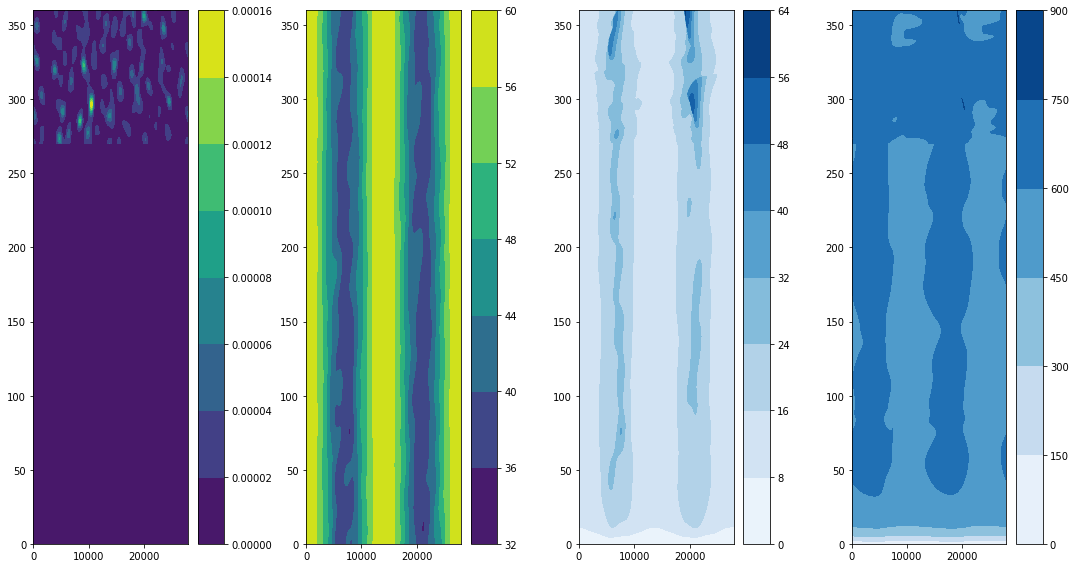

In [39]:
plt.figure(figsize=(15,8))
plt.subplot(1,4,1)
plt.contourf(x/1000,t/86400, S);    plt.colorbar()
plt.subplot(1,4,2)
plt.contourf(x/1000,t/86400, C);    plt.colorbar()
plt.subplot(1,4,3)
plt.contourf(x/1000,t/86400, Ahat, cmap=plt.cm.Blues); plt.colorbar()
plt.subplot(1,4,4)
plt.contourf(x/1000,t/86400, F, cmap=plt.cm.Blues); plt.colorbar()

plt.tight_layout()

In [104]:
## How to slowly change Uref ##
year=5
model.tmin = year*360*86400#(year*360)*86400
model.tmax = (year+1)*360*86400 #((year+1)*360)*86400  
cond.beta  = 70 #betas[year]
#logging.debug(" year = %i and beta = %1.2f"%(year, betas[year]))
model.beta = cond.beta
model.run_some_years()

setup = h5py.File(model.path+"/setup.h5")
fnis  = np.array(sorted(glob.glob(model.path+"snapshots/*.h5")))


In [105]:
Ahat, F, S, C = 0,0,0,0
t = []
for fni in fnis[(360*4)*0::2]:
    snap = h5py.File(fni)
    t.append(snap['t'][()])
    try:
        Ahat = np.vstack([Ahat, snap['A'][:]])
        F = np.vstack([F, snap['F'][:]])
        S = np.vstack([S, snap['S'][:]])
        C = np.vstack([C, snap['C'][:]])
    except:
        Ahat = snap['A'][:]
        F = snap['F'][:]
        S = snap['S'][:]
        C = snap['C'][:]

t = np.array(t)


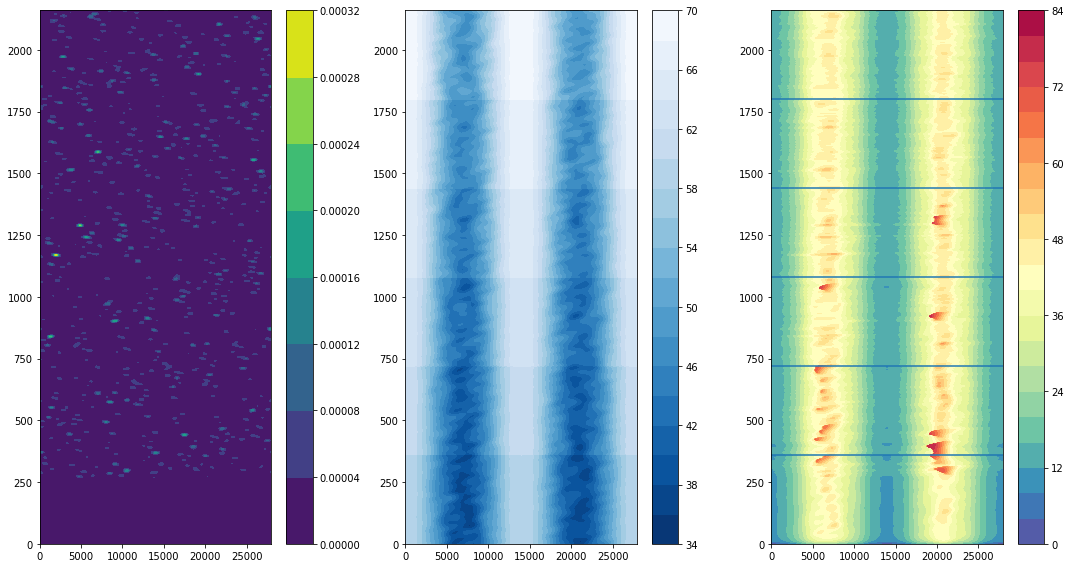

In [107]:
u= cond.beta-cond.alpha*(Ahat+model.A0[np.newaxis,:])
plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
plt.contourf(x/1000,t/86400, S);    plt.colorbar()
plt.subplot(1,3,2)
plt.contourf(x/1000,t/86400, C, 20, cmap=plt.cm.Blues_r);    plt.colorbar()
plt.subplot(1,3,3)
plt.contourf(x/1000,t/86400, (Ahat+model.A0[np.newaxis,:]), 20, cmap=plt.cm.Spectral_r); plt.colorbar()
plt.axhline(360)
plt.axhline(360*2)
plt.axhline(360*3)
plt.axhline(360*4)
plt.axhline(360*5)

plt.tight_layout()

In [ ]:
#### Intitalizing the model #######


def slow_change_uref(beta_initial=80,beta_final=8, decades = 1):
    
    noisy_initc = noisyconditions(cfunc=noisybackground, cxpeak=0.5,Y=10, nwcx=21, n=2, \
                                peak=2, nwforce=26, background=True,forcing=True,beta=beta_initial, alpha=0.55)

    cond = noisy_initc
    wavenum=2

    model = AtmosphericBlocking.Model(nx=1024,Lx = 28000e3,dt=.005*86400,alpha=cond.alpha,
                                            tmax=3.5*86400,D=3.26e5,tau=cond.tau,
                                            sfunc=cond.forcing,cfunc=cond.getcx,
                                            forcingpeak=cond.peak,injection=cond.inject,
                                            save_to_disk=True,
                                            overwrite=True,
                                            tsave_snapshots=50,
                                            path = 'output_slow_change_Uref/')
    
    
    no_of_days          = decades*10*360 
    no_of_years         = decades*10
    no_of_seconds       = no_of_days*86400
    betas               = np.linspace(beta_initial, beta_final, no_of_years)
    delta_beta_per_year = betas[1]-betas[0] 
    
    ### How to slowly change Uref ##
    
    for year in range(0,no_of_years):
        model.tmin = (year*360)*86400
        model.tmax = ((year+1)*360)*86400  
        cond.beta  = betas[year]
        logging.debug(" year = %i and beta = %1.2f"%(year, betas[year]))
        model.run_some_years()
    
    
if __name__=="__main__":    
    slow_change_uref(beta_initial=80,beta_final=30, decades = 10)
    




